## Demo code to load the best V1T model and inference on the Sensorium+ test set

Please follow the instruction in [README.md](README.md) to set up the conda environment.

In [21]:
import torch
import typing as t
from tqdm import tqdm
from torch.utils.data import DataLoader

from v1t import data
from v1t.utils import utils
from v1t.models import Model
from v1t.metrics import Metrics
from v1t.utils.scheduler import Scheduler

dummy arg object to mimic argparse

In [22]:
class Args:
    def __init__(self):
        self.device = torch.device("cpu")
        self.batch_size = 16
        self.output_dir = "runs/best_v1t_sensorium"
        self.dataset = "data/sensorium"

In [23]:
args = Args()
utils.load_args(args)  # load arguments from checkpoint

load Sensorium+ test set

In [24]:
_, _, test_ds = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

initialize model and restore checkpoint

In [25]:
model = Model(args, ds=test_ds)
model.to(args.device)

scheduler = Scheduler(args, model=model, save_optimizer=False)
_ = scheduler.restore(force=True)


Loaded checkpoint from epoch 120 (correlation: 0.4612).



In [26]:
@torch.no_grad()
def inference(
    ds: DataLoader,
    model: torch.nn.Module,
    batch_size: int,
    device: torch.device = "cpu",
) -> t.Dict[str, torch.Tensor]:
    """Inference data in DataLoader ds
    Returns:
        results: t.Dict[int, t.Dict[str, torch.Tensor]]
            - mouse_id
                - predictions: torch.Tensor, predictions given images
                - targets: torch.Tensor, the ground-truth responses
                - trial_ids: torch.Tensor, trial ID of the responses
                - image_ids: torch.Tensor, image ID of the responses
    """
    results = {
        "predictions": [],
        "targets": [],
        "trial_ids": [],
        "image_ids": [],
    }
    mouse_id = ds.dataset.mouse_id
    model.to(device)
    model.train(False)
    for batch in tqdm(ds, desc=f"Mouse {data.convert_id(mouse_id)}"):
        for micro_batch in data.micro_batching(batch, batch_size=batch_size):
            predictions, _, _ = model(
                inputs=micro_batch["image"].to(device),
                mouse_id=mouse_id,
                behaviors=micro_batch["behavior"].to(device),
                pupil_centers=micro_batch["pupil_center"].to(device),
            )
            results["predictions"].append(predictions.cpu())
            results["targets"].append(micro_batch["response"])
            results["image_ids"].append(micro_batch["image_id"])
            results["trial_ids"].append(micro_batch["trial_id"])
    results = {
        k: torch.cat(v, dim=0) if isinstance(v[0], torch.Tensor) else v
        for k, v in results.items()
    }
    return results

In [27]:
for mouse_id in ["2", "3", "4", "5", "6"]:
    outputs = inference(
        ds=test_ds[mouse_id],
        model=model,
        batch_size=args.batch_size,
        device=args.device,
    )
    metrics = Metrics(ds=test_ds[mouse_id], results=outputs)

    single_trial_correlation = metrics.single_trial_correlation(per_neuron=False)
    correlation_to_average = metrics.correlation_to_average(per_neuron=False)
    print(
        f"single trial correlation: {single_trial_correlation:.03f}\n"
        f"correlation to average: {correlation_to_average:.03f}\n"
    )

Mouse A: 100%|██████████| 63/63 [01:54<00:00,  1.82s/it]


single trial correlation: 0.401
correlation to average: 0.597



Mouse B: 100%|██████████| 63/63 [01:53<00:00,  1.81s/it]


single trial correlation: 0.464
correlation to average: 0.666



Mouse C: 100%|██████████| 62/62 [01:52<00:00,  1.81s/it]


single trial correlation: 0.430
correlation to average: 0.638



Mouse D: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


single trial correlation: 0.436
correlation to average: 0.637



Mouse E: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]

single trial correlation: 0.401
correlation to average: 0.609



## Extract attention rollout maps for Mouse A

See [misc/vit_visualization.py](misc/vit_visualization.py) for more.

In [28]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from v1t.utils import tensorboard
from v1t.utils.attention_rollout import attention_rollout, Recorder

In [29]:
def plot_attention_map(
    val_results: t.List[t.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]],
    test_results: t.List[t.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]],
    colormap: str = "turbo",
    alpha: float = 0.5,
):
    assert len(val_results) == len(test_results) == 3
    cmap = cm.get_cmap(colormap)
    colors = cmap(np.arange(256))[:, :3]
    label_fontsize, tick_fontsize = 10, 8
    figure, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(8, 4),
        gridspec_kw={"wspace": 0.05, "hspace": -0.25},
        dpi=240,
        facecolor="white",
    )
    for i, (image, heatmap, behavior, pupil_center) in enumerate(val_results):
        image = image[0]
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        image = image[..., None]
        heatmap = alpha * heatmap + (1 - alpha) * image
        axes[0, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[0, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[0, i].set_xlabel(description, labelpad=0, fontsize=tick_fontsize)
    axes[0, 0].set_ylabel("Validation samples", labelpad=0.05, fontsize=tick_fontsize)
    for i, (image, heatmap, behavior, pupil_center) in enumerate(test_results):
        image = image[0]
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        image = image[..., None]
        heatmap = alpha * heatmap + (1 - alpha) * image
        axes[1, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[1, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[1, i].set_xlabel(description, labelpad=0, fontsize=tick_fontsize)
    axes[-1, 0].set_ylabel("Test samples", labelpad=0.05, fontsize=tick_fontsize)

    # plot colorbar
    pos1 = axes[0, -1].get_position()
    pos2 = axes[-1, -1].get_position()
    width, height = 0.008, (pos1.y1 - pos1.y0) * 0.35
    cbar_ax = figure.add_axes(
        rect=[
            pos1.x1 + 0.01,
            ((pos1.y1 - pos2.y0) / 2 + pos2.y0) - (height / 2),
            width,
            height,
        ]
    )
    figure.colorbar(cm.ScalarMappable(cmap=colormap), cax=cbar_ax, shrink=0.1)
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 3),
        tick_fontsize=tick_fontsize,
    )
    tensorboard.set_ticks_params(axis=cbar_ax)

    plt.show()

load validation and test set with batch size of 1

In [30]:
_, val_ds, test_ds = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=1,
    device=args.device,
)

In [31]:
num_plots = 3  # number of maps to extract from each set
mouse_id = "2"  # mouse 2 -> mouse A
recorder = Recorder(model.core)

In [32]:
val_results = []
for batch in val_ds[mouse_id]:
    with torch.no_grad():
        pupil_center = batch["pupil_center"]
        # pupil_center = torch.zeros_like(pupil_center)
        behavior = batch["behavior"]
        # behavior = torch.zeros_like(behavior)
        image, _ = model.image_cropper(
            inputs=batch["image"],
            mouse_id=mouse_id,
            behaviors=behavior,
            pupil_centers=pupil_center,
        )
        _, attention = recorder(
            images=image,
            behaviors=behavior,
            pupil_centers=pupil_center,
            mouse_id=mouse_id,
        )
        image = val_ds[mouse_id].dataset.i_transform_image(image)
        recorder.clear()
    image, attention = image.numpy()[0], attention.numpy()[0]
    heatmap = attention_rollout(image=image, attention=attention)
    val_results.append((image, heatmap, behavior.numpy()[0], pupil_center.numpy()[0]))
    if len(val_results) == num_plots:
        break

test_results = []
for batch in test_ds[mouse_id]:
    with torch.no_grad():
        pupil_center = batch["pupil_center"]
        behavior = batch["behavior"]
        image, _ = model.image_cropper(
            inputs=batch["image"],
            mouse_id=mouse_id,
            behaviors=behavior,
            pupil_centers=pupil_center,
        )
        _, attention = recorder(
            images=image,
            behaviors=behavior,
            pupil_centers=pupil_center,
            mouse_id=mouse_id,
        )
        image = val_ds[mouse_id].dataset.i_transform_image(image)
        recorder.clear()
    image, attention = image.numpy()[0], attention.numpy()[0]
    heatmap = attention_rollout(image=image, attention=attention)
    test_results.append((image, heatmap, behavior.numpy()[0], pupil_center.numpy()[0]))
    if len(test_results) == num_plots:
        break

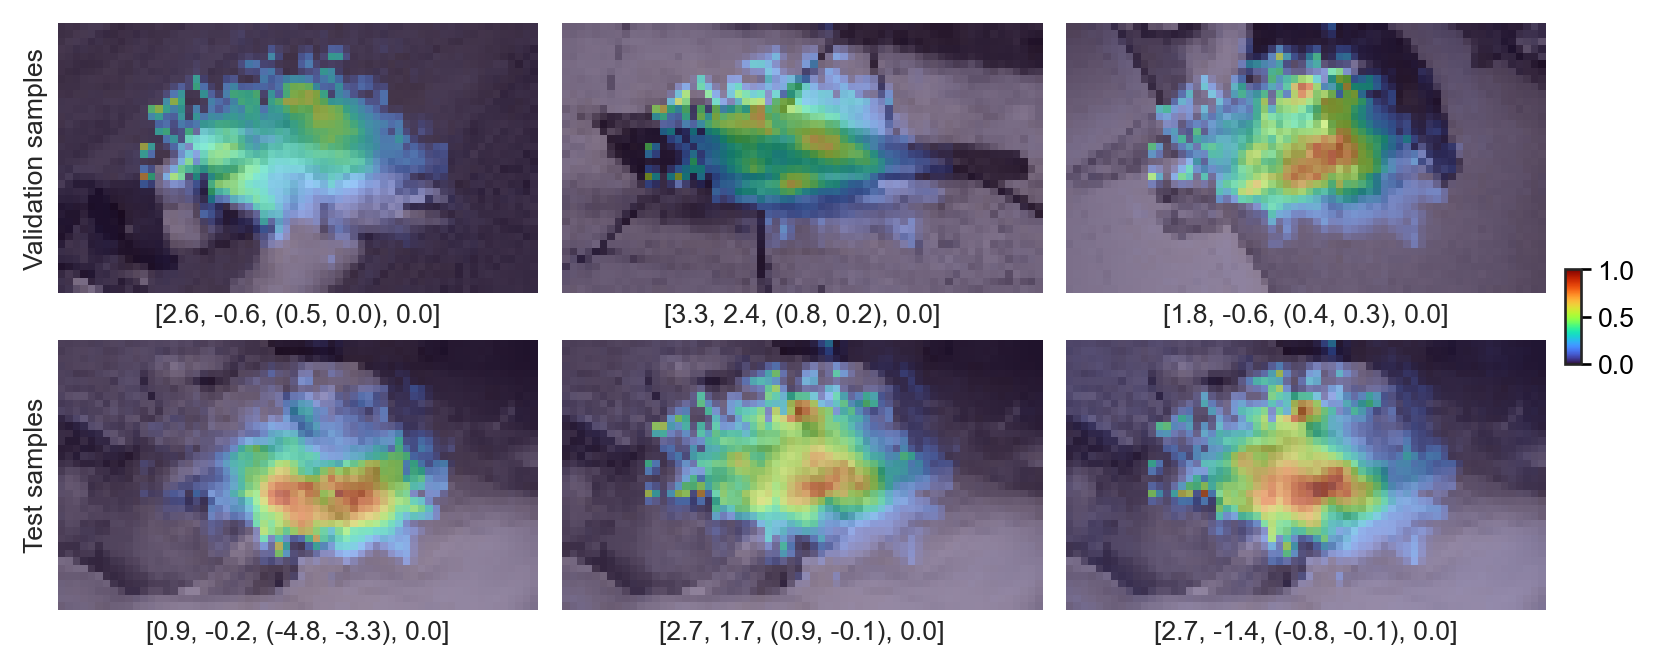

In [33]:
plot_attention_map(val_results=val_results, test_results=test_results)

Please check [misc/](misc/) for code to generate plots and figures used in the paper.